# Overfitting and Regularization

## Imports

In [258]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [259]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [260]:
set_config(display='diagram')

## Settings

In [261]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [262]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

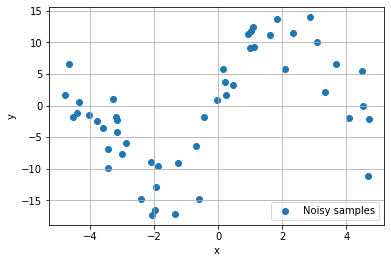

In [263]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

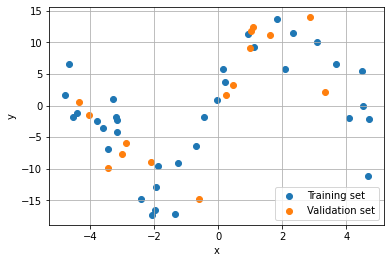

In [264]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [265]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [266]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [267]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

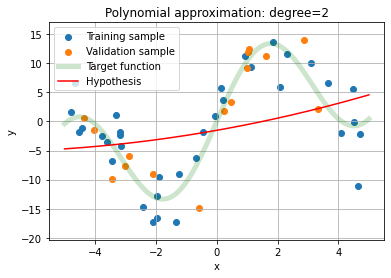

In [268]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

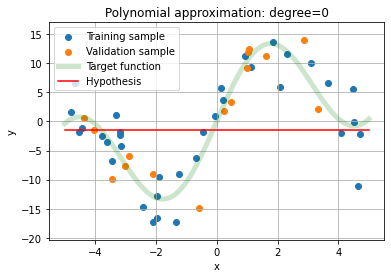

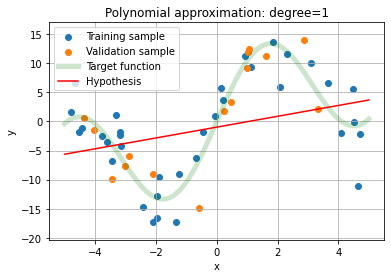

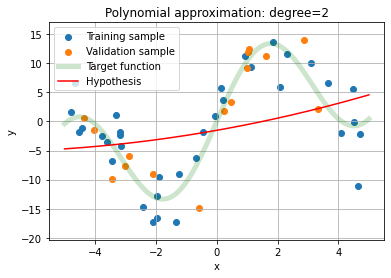

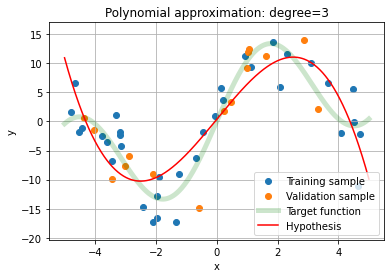

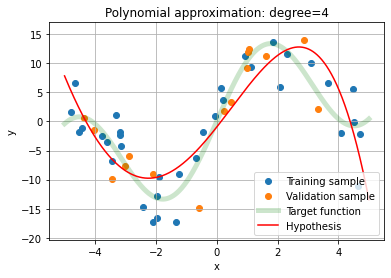

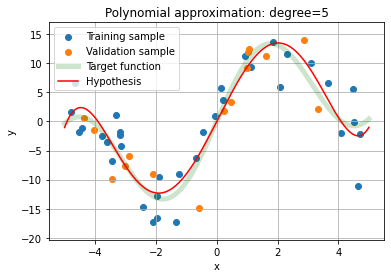

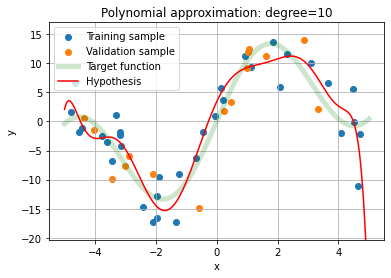

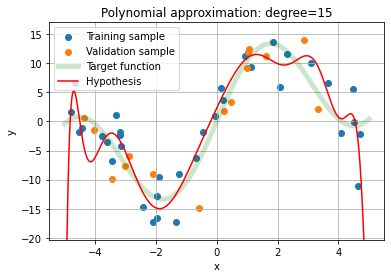

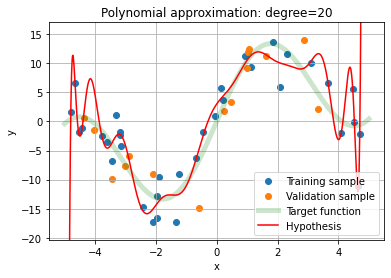

In [269]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

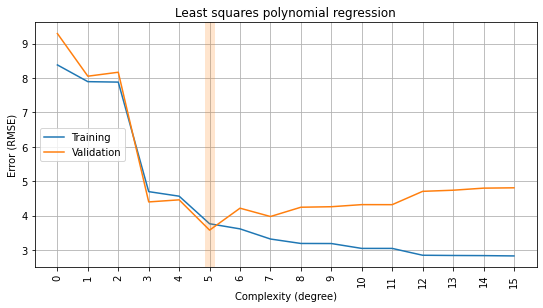

In [270]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [271]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

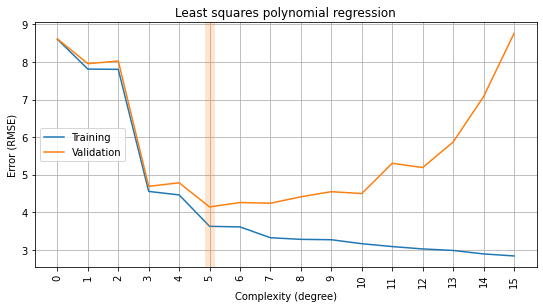

In [272]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [273]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

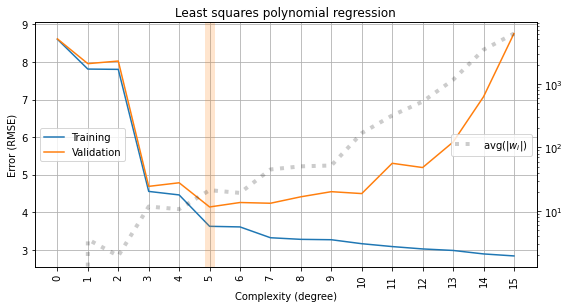

In [274]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

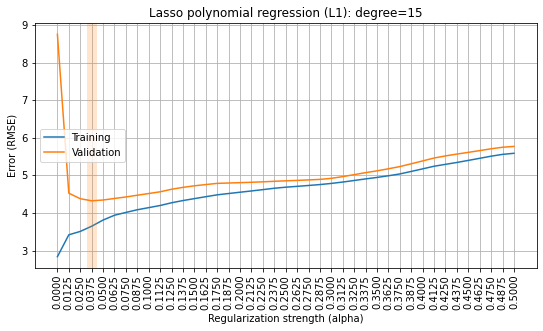

In [275]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

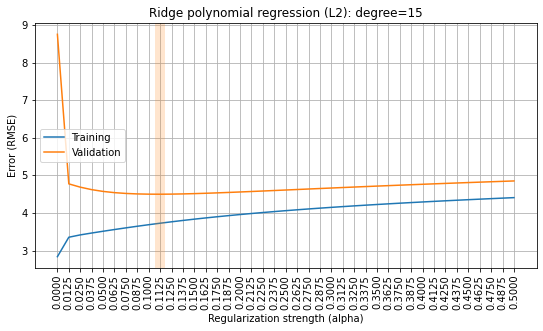

In [276]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

In [277]:
def plot_fitting_graph(
        x, metric_train, metric_valid, xlabel, ylabel,
        custom_metric=None, custom_label='',
        custom_scale='log', title='Fitting graph',
        axv_line = None
):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    if axv_line is None:
        axv_line = x[np.argmin(metric_valid)]
    plt.axvline(axv_line, color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label)
        plt.legend(loc='center right')
    plt.show()

In [278]:
def poly_and_scale(
       *, x_t, x_v, degree, poly_features
):
    poly = PolynomialFeatures(degree=degree, include_bias=(degree == 0))
    scaler = StandardScaler()

    xt_pf = x_t[poly_features]
    xt_wo_pf = x_t.drop(columns=poly_features)
    xv_pf = x_v[poly_features]
    xv_wo_pf = x_v.drop(columns=poly_features)

    xt_poly = poly.fit_transform(xt_pf)
    xv_poly = poly.transform(xv_pf)

    xt_sca = scaler.fit_transform(xt_poly)
    xv_sca = scaler.transform(xv_poly)

    xt_all = np.append(xt_sca, xt_wo_pf, axis=1)
    xv_all = np.append(xv_sca, xv_wo_pf, axis=1)

    return xt_all, xv_all

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [279]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

Let's split dataset on the train and test sets.

### Notes
* Feature `'s4'` were selected as polynomial feature
* Cross validation were not used because there is required more computing power
* Because the results are extremely strange, it will be assumed that they are true and conclusions will be drawn from the results. However, this does not invalidate the fact that there is an error somewhere (or everywhere)

In [280]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)
POLY_FEATURE = ['s4']

In [281]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    model = LinearRegression()
    xt, xv = poly_and_scale(
        x_t=X_train, x_v=X_valid, degree=degree, poly_features=POLY_FEATURE)
    model.fit(xt, y_train)

    rmse_train.append(rmse(model.predict(xt), y_train))
    rmse_valid.append(rmse(model.predict(xv), y_valid))

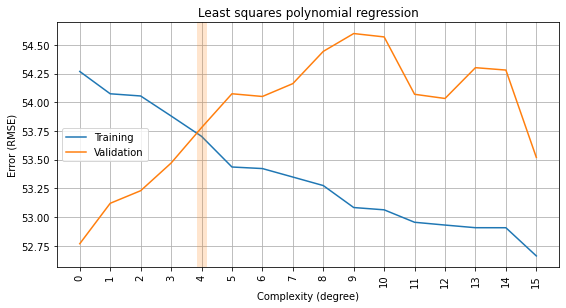

In [282]:
plot_fitting_graph(
    DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)',
    ylabel='Error (RMSE)', title='Least squares polynomial regression',
    axv_line=4)

The standard behavior of the training data error graph is its constant decrease, which is what is observed. The best degree is at the place where the error on the test data is minimal (so de minimis the difference between the errors on the test and training data). Up to this mark is the area of underfitting, after that the area of overfitting. Since the error on the test data is constantly increasing on this graph, **the best degree was chosen as the intersection point of the error graphs - degree 4**.

However, the RMSE value is huge, which suggests that there is an error somewhere in the code

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [283]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    model = LinearRegression()
    xt, xv = poly_and_scale(
        x_t=X_train, x_v=X_valid, degree=degree, poly_features=POLY_FEATURE)
    model.fit(xt, y_train)

    rmse_train.append(rmse(model.predict(xt), y_train))
    rmse_valid.append(rmse(model.predict(xv), y_valid))
    avg_coef.append(np.abs(model.coef_).mean())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


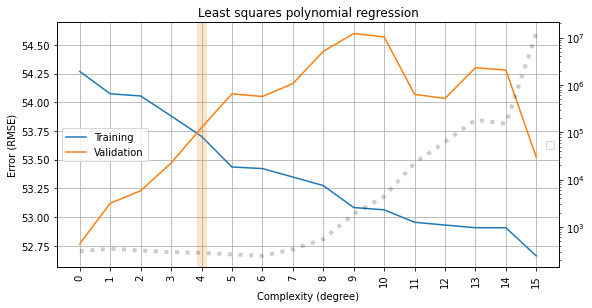

In [284]:
plot_fitting_graph(
    DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)',
    ylabel='Error (RMSE)', title='Least squares polynomial regression',
    custom_metric=avg_coef, axv_line=4
)

For comparison, here is a graph of the linear regression error as a function of degree, where we also indicate a graph of the average coefficient of the model.

#### L1

In [285]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:

    model = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    xt, xv = poly_and_scale(
        x_t=X_train, x_v=X_valid, degree=15, poly_features=POLY_FEATURE)
    model.fit(xt, y_train)

    rmse_train.append(rmse(model.predict(xt), y_train))
    rmse_valid.append(rmse(model.predict(xv), y_valid))
    avg_coef.append(np.abs(model.coef_).mean())

C:\Users\Opiakos\AppData\Local\Temp\ipykernel_5864\2444524298.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(xt, y_train)
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.371e+05, tolerance: 1.900e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


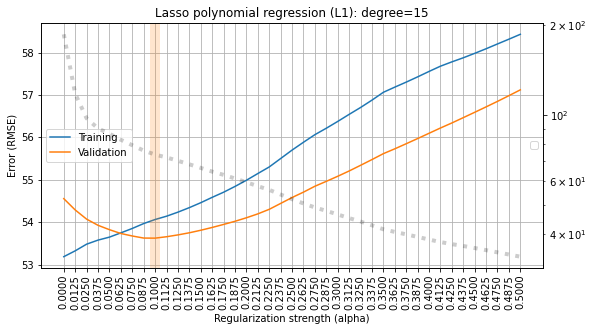

In [286]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15',
                   custom_metric=avg_coef)

Here we observe an atypical behavior of the error graph on the training data. However, there is a minimum error in the training data, so it is considered that **the best value of alpha is 0.1**

#### L2

In [287]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:

    model = Ridge(alpha=alpha, random_state=SEED, max_iter=50000)
    xt, xv = poly_and_scale(
        x_t=X_train, x_v=X_valid, degree=15, poly_features=POLY_FEATURE)
    model.fit(xt, y_train)

    rmse_train.append(rmse(model.predict(xt), y_train))
    rmse_valid.append(rmse(model.predict(xv), y_valid))
    avg_coef.append(np.abs(model.coef_).mean())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


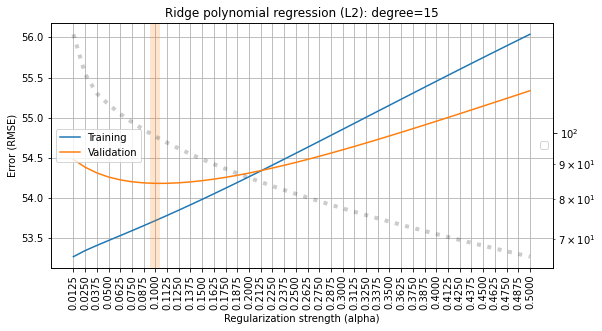

In [288]:
plot_fitting_graph(ALPHAS[1:], rmse_train[1:], rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2): degree=15',
                   custom_metric=avg_coef[1:])

Here we observe an atypical behavior of the error graph on the training data too. The first element was not drawn on the graph because it interferes. However, there is a minimum error in the training data, so it is considered that **the best value of alpha is 0.1** too.

#### Summary

In the following, the results will be considered in terms of a decrease in the mean value of the coefficients as the alpha increases. In both L1 and L2, a decrease is observed, but for L1 the decrease is much faster than for L2.

Visually, the graphs starting with an alpha of 0.05 have a linear relationship with the same slope, but the first values of the alpha in the case of L1 decrease the mean value of the coefficients more than L2.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [289]:
def plot_zeros_percentage(x_ticks, y_ticks, axis: plt.Axes, feat_name: str):
    sns.lineplot(x=x_ticks, y=y_ticks, ax=axis)
    axis.set_title(f'the proportion of zero coefficients for the \'{feat_name}\'')
    axis.set_xlabel('Alpha')
    axis.set_ylabel('The proportion')

In [290]:
def calc_zeros(penalty, poly_feature: str):
    zeros_percentage = []
    for alpha in ALPHAS:

        if penalty == 'L1':
            model = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
        elif penalty == 'L2':
            model = Ridge(alpha=alpha, random_state=SEED, max_iter=50000)
        xt, xv = poly_and_scale(
            x_t=X_train, x_v=X_valid, degree=15, poly_features=[poly_feature])
        model.fit(xt, y_train)

        zeros = np.sum(np.isclose(model.coef_, 0))
        non_zeros = np.count_nonzero(model.coef_)
        zeros_percentage.append(zeros / (zeros + non_zeros))
    return zeros_percentage


#### L1

In [291]:
feature_dict = {}
column_count = len(X_train.columns)
for column in X_train:
    feature_dict[column] = calc_zeros('L1', column)

C:\Users\Opiakos\AppData\Local\Temp\ipykernel_5864\2773913148.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(xt, y_train)
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.346e+05, tolerance: 1.900e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model =

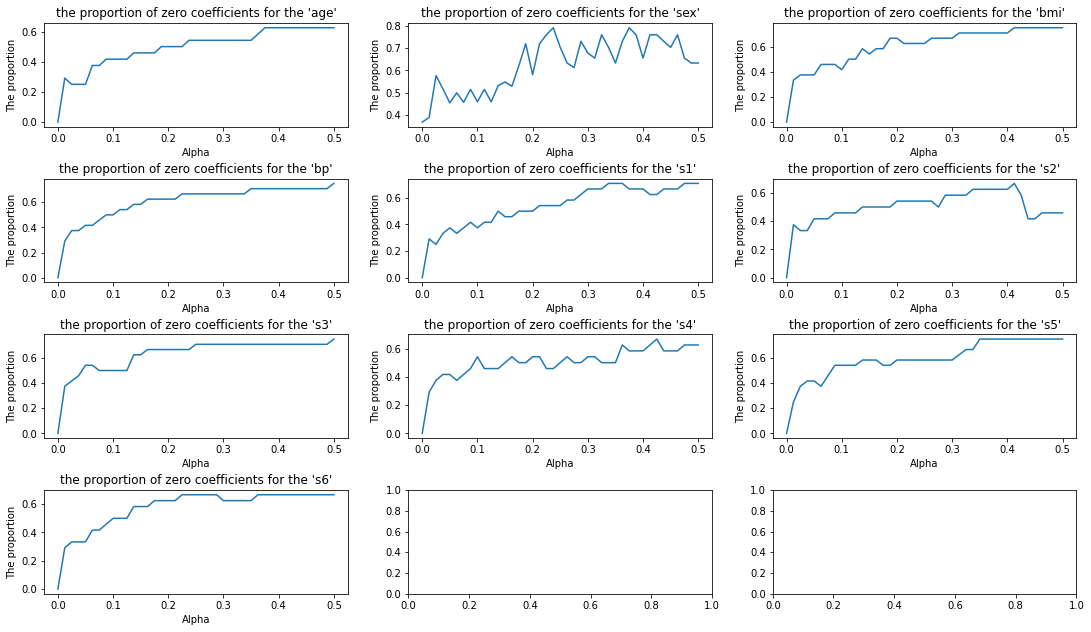

In [292]:
fig, ax = plt.subplots(4, 3)
ax_flat = ax.flatten()
for i_feat, (column, zeros) in enumerate(feature_dict.items()):
    plot_zeros_percentage(ALPHAS, zeros, ax_flat[i_feat], column)
fig.set_size_inches(18.5, 10.5)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### L2

In [293]:
feature_dict = {}
column_count = len(X_train.columns)
for column in X_train:
    feature_dict[column] = calc_zeros('L2', column)

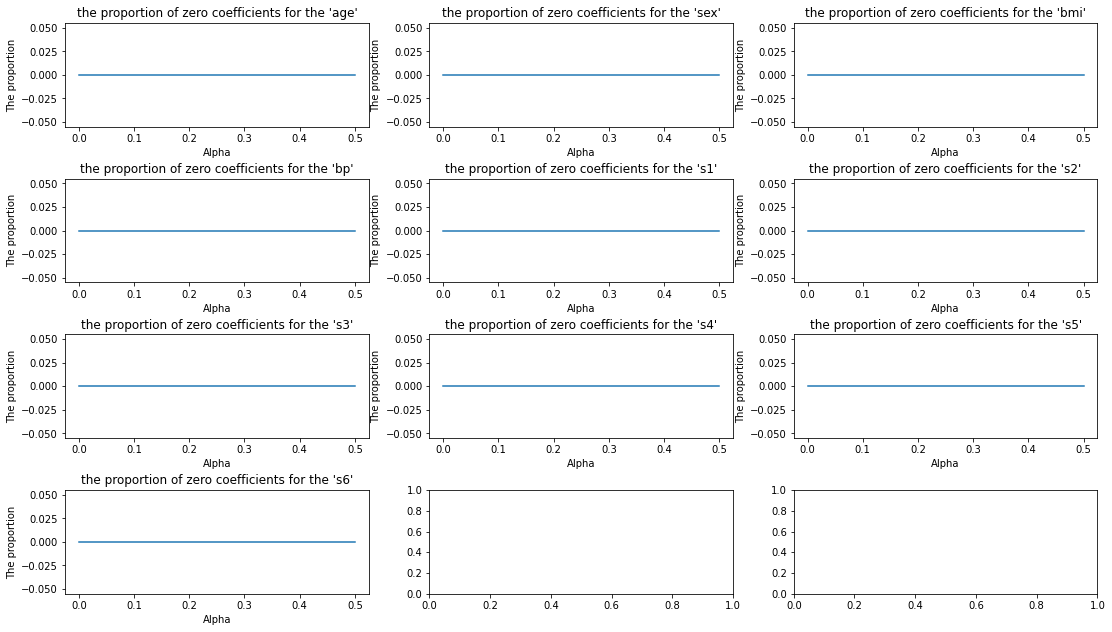

In [294]:
fig, ax = plt.subplots(4, 3)
ax_flat = ax.flatten()
for i_feat, (column, zeros) in enumerate(feature_dict.items()):
    plot_zeros_percentage(ALPHAS, zeros, ax_flat[i_feat], column)
fig.set_size_inches(18.5, 10.5)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### Summary

As we can see, L2 is really not suitable for feature selection, there are no zero coefficients in all cases. For L1 there is indeed an increase in the proportion of null coefficients with increasing alpha. However, it is not imaginable to judge whether the feature is suitable, because in my opinion the general behavior of all graphs is the same

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [296]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

In [297]:
## your code

#### L2

In [298]:
## your code

#### Summary



In [299]:
## your observations/conclusions

# Appendix 1